In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pytorchcv import train, plot_results

In [5]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.LazyBatchNorm2d(), nn.ReLU())

In [6]:
class NiN(nn.Module):
    def __init__(self, lr = 0.1, num_classes = 10):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())

    def forward(self, X):
        return self.net(X)

    def layer_summary(self, input_size):
        X = torch.randn(*input_size)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__,'output shape:\t', X.shape)

In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
data_train = datasets.MNIST(
    root = './data',
    train = True,
    download = False,
    transform = trans
)

data_val = datasets.MNIST(
    root = './data',
    train = False,
    download = False,
    transform = trans
)

In [8]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
net = NiN()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
net.layer_summary(input_size = [1,1,224,224])

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [12]:
!pip install torchinfo

from torchinfo import summary
summary(net, input_size = [1,1,224,224])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
NiN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-1                  [1, 96, 54, 54]           11,712
│    │    └─BatchNorm2d: 3-2             [1, 96, 54, 54]           192
│    │    └─ReLU: 3-3                    [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-4                  [1, 96, 54, 54]           9,312
│    │    └─BatchNorm2d: 3-5             [1, 96, 54, 54]           192
│    │    └─ReLU: 3-6                    [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-7                  [1, 96, 54, 54]           9,312
│    │    └─BatchNorm2d: 3-8             [1, 96, 54, 54]           192
│    │    └─ReLU: 3-9                    [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-2                    [1, 96, 26, 26]           --
│ 

In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train(net, train_loader, val_loader, optimizer = optimizer, epochs = 3, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.956, Val acc=0.986, Train loss=0.001, Val loss=0.000
Epoch  1, Train acc=0.987, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.991, Val acc=0.990, Train loss=0.000, Val loss=0.000


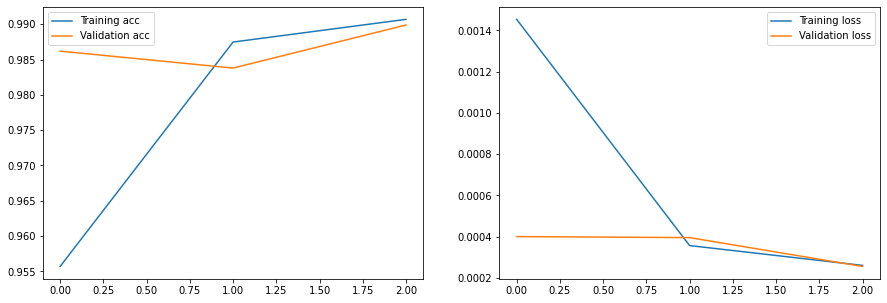

In [16]:
plot_results(hist)

In [19]:
!wget https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py

--2023-03-26 07:56:32--  https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10120 (9.9K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   9.88K  --.-KB/s    in 0.001s  

2023-03-26 07:56:33 (7.90 MB/s) - ‘utils.py.1’ saved [10120/10120]



In [21]:
import utils

Text(0.5, 1.0, 'label: 9')

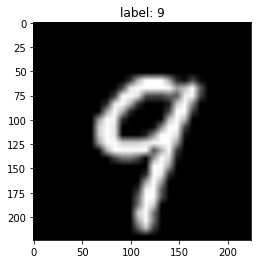

In [25]:
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(f'label: {label}')

In [33]:
img_ = img.unsqueeze(0)
print(type(img_))
print(img_.shape)

<class 'torch.Tensor'>
torch.Size([1, 1, 224, 224])


In [36]:
prob = net(img_.to('cuda'))
print(prob)

tensor([[0.0000e+00, 1.4976e-01, 0.0000e+00, 2.8287e+01, 7.1408e-01, 2.9794e+01,
         1.6439e+00, 0.0000e+00, 4.6820e+01, 4.2866e+02]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)


In [38]:
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-38-30cebcf08ff6>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


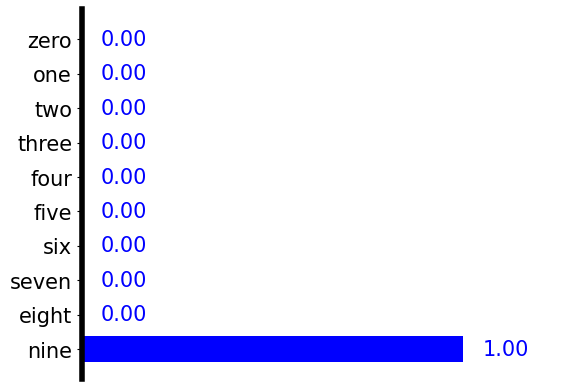

In [40]:
utils.show_prob_mnist(prob.to('cpu'))